In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
import matplotlib as mpl
from mquad.mquad_utils import findKnee

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

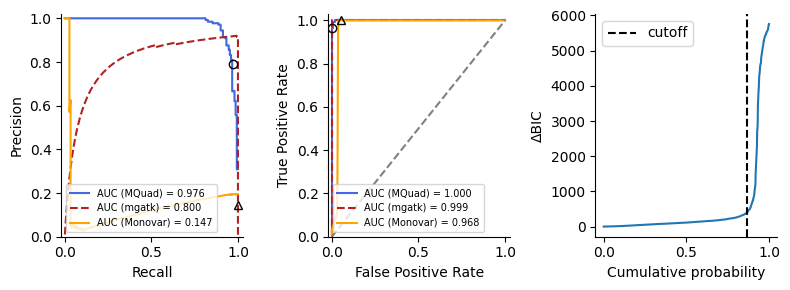

In [4]:
mquad = process_mquad_data(50,10)
mgatk = process_mgatk_data(50,10)
merged_with_mquad = process_monovar_data(50,10)

fpr_mquad, tpr_mquad, auc_mquad, precision_mquad, recall_mquad, aps_mquad = calculate_metrics(mquad.truth, mquad.deltaBIC)
fpr_mgatk, tpr_mgatk, auc_mgatk, precision_mgatk, recall_mgatk, aps_mgatk = calculate_metrics(mgatk.truth, mgatk.vmr)
fpr_mono, tpr_mono, auc_mono, precision_mono,recall_mono, aps_mono = calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.subplot(1,3,1)
plt.plot(recall_mquad, precision_mquad, 'royalblue', label = 'AUC (MQuad) = %0.3f' % aps_mquad)
p_mgatk,r_mgatk = PR_curve(mgatk.truth, mgatk.vmr)
plt.plot(r_mgatk, p_mgatk, 'firebrick', linestyle='--', label = 'AUC (mgatk) = %0.3f' % aps_mgatk)
plt.plot(recall_mono, precision_mono, 'orange', label = 'AUC (Monovar) = %0.3f' % aps_mono)

plt.plot(0.97, 0.79, marker='o', fillstyle='none', color='black')
plt.plot(1.0, 0.144, marker='^', fillstyle='none', color='black')

plt.legend(loc='lower left', prop={'size': 7})
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.02, 1.03])
plt.ylim([0, 1.02])

plt.subplot(1,3,2)
plt.plot(fpr_mquad, tpr_mquad, 'royalblue', label = 'AUC (MQuad) = %0.3f' % auc_mquad)
plt.plot(fpr_mgatk, tpr_mgatk, 'firebrick', linestyle='--', label = 'AUC (mgatk) = %0.3f' % auc_mgatk)
plt.plot(fpr_mono, tpr_mono, 'orange', label = 'AUC (Monovar) = %0.3f' % auc_mono)
plt.plot(38/(16023+38), 145/150, marker='o', fillstyle='none', color='black')
plt.plot(895/(15166+895), 1, marker='^', fillstyle='none', color='black')
plt.legend(loc='lower left',  prop={'size': 7})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'--', color='grey')
plt.xlim([-0.02, 1.03])
plt.ylim([0, 1.03])

plt.subplot(1,3,3)
x,y,knee_x, knee_y = findKnee(mquad.deltaBIC)
plt.plot(x, y)
plt.axvline(x=knee_x, color="black", linestyle='--',label="cutoff")
plt.legend()
plt.ylabel("\u0394BIC")
plt.xlabel("Cumulative probability")

plt.tight_layout()

plt.savefig('figures/curves.pdf')

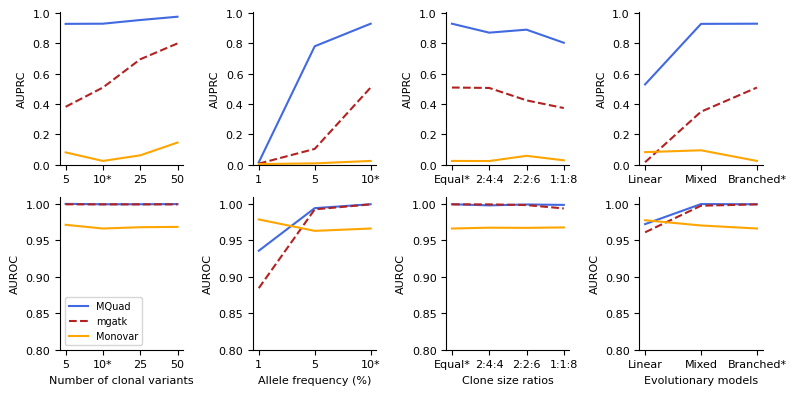

In [5]:
from sklearn import metrics
# ROC
#mgatk.dropna(inplace=True)
def calculate_metrics(truth, score):
    fpr, tpr, threshold =  metrics.roc_curve(truth, score)
    auroc = metrics.auc(fpr, tpr)

    precision, recall, threshold = metrics.precision_recall_curve(truth, score)
    auprc = metrics.average_precision_score(truth, score)

    return fpr, tpr, auroc, precision, recall, auprc

n_mut = [5, 10, 25, 50]
str_n_mut = ['5', '10*', '25', '50']
af_pct = [1, 5, 10]
str_af_pct = ['1', '5', '10*']
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

auroc_mquad, auroc_mgatk, auroc_monovar = [],[],[]
auprc_mquad, auprc_mgatk, auprc_monovar = [],[],[]

for n in n_mut:
    mgatk = process_mgatk_data(n, 10)
    mquad = process_mquad_data(n, 10)
    merged_with_mquad = process_monovar_data(n, 10)

    auroc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[2])
    auroc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[2])
    auroc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[2])

    auprc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[5])
    auprc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[5])
    auprc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[5])

plt.style.use('default')
font = {'family' : 'sans-serif',
        #'sans-serif' : 'Arial',
        'size'   : 8}
plt.rc('font', **font)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize=(8, 4))
plt.subplot(2,4,1)
plt.plot(str_n_mut, auprc_mquad, label="MQuad", color="royalblue")
plt.plot(str_n_mut, auprc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_n_mut, auprc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('Varying no. of clonal variants')
#plt.xlabel('Number of clonal variants')
plt.ylabel('AUPRC')
plt.ylim((0, 1.01))

plt.subplot(2,4,5)
plt.plot(str_n_mut, auroc_mquad, label="MQuad", color="royalblue")
plt.plot(str_n_mut, auroc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_n_mut, auroc_monovar, label="Monovar", color="orange")
plt.legend(loc='lower left', prop={'size': 7})
#plt.title('Varying no. of clonal variants')
plt.xlabel('Number of clonal variants')
plt.ylabel('AUROC')
plt.ylim((0.8, 1.01))

auroc_mquad, auroc_mgatk, auroc_monovar = [],[],[]
auprc_mquad, auprc_mgatk, auprc_monovar = [],[],[]

for a in af_pct:
    mgatk = process_mgatk_data(10, a)
    mquad = process_mquad_data(10, a)
    merged_with_mquad = process_monovar_data(10, a)

    auroc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[2])
    auroc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[2])
    auroc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[2])

    auprc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[5])
    auprc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[5])
    auprc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[5])

plt.subplot(2,4,2)
plt.plot(str_af_pct, auprc_mquad, label="MQuad", color="royalblue")
plt.plot(str_af_pct, auprc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_af_pct, auprc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('Varying allele frequencies')
#plt.xlabel('Allele frequency (%)')
plt.ylabel('AUPRC')
plt.ylim((0, 1.01))

plt.subplot(2,4,6)
plt.plot(str_af_pct, auroc_mquad, label="MQuad", color="royalblue")
plt.plot(str_af_pct, auroc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_af_pct, auroc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('AUROC - Varying allele frequencies')
plt.xlabel('Allele frequency (%)')
plt.ylabel('AUROC')
plt.ylim((0.8, 1.01))


auroc_mquad, auroc_mgatk, auroc_monovar = [],[],[]
auprc_mquad, auprc_mgatk, auprc_monovar = [],[],[]

sizes = [None, '244', '226', '118']
str_sizes = ['Equal*', '2:4:4', '2:2:6', '1:1:8']
for s in sizes:
    mgatk = process_mgatk_data(10, 10, s)
    mquad = process_mquad_data(10, 10, s)
    merged_with_mquad = process_monovar_data(10, 10, s)

    auroc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[2])
    auroc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[2])
    auroc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[2])

    auprc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[5])
    auprc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[5])
    auprc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[5])

plt.subplot(2,4,3)
plt.plot(str_sizes, auprc_mquad, label="MQuad", color="royalblue")
plt.plot(str_sizes, auprc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_sizes, auprc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('Varying clone sizes')
#plt.xlabel('Clone size ratios')
plt.ylabel('AUPRC')
plt.ylim((0, 1.01))

plt.subplot(2,4,7)
plt.plot(str_sizes, auroc_mquad, label="MQuad", color="royalblue")
plt.plot(str_sizes, auroc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_sizes, auroc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('AUROC - Varying clone sizes')
plt.xlabel('Clone size ratios')
plt.ylabel('AUROC')
plt.ylim((0.8, 1.01))

auroc_mquad, auroc_mgatk, auroc_monovar = [],[],[]
auprc_mquad, auprc_mgatk, auprc_monovar = [],[],[]
tree = ['linear', 'branched', None]
str_tree = ['Linear', 'Mixed', 'Branched*']

for t in tree:
    mgatk = process_mgatk_data(10, 10, tree=t)
    mquad = process_mquad_data(10, 10, tree=t)
    merged_with_mquad = process_monovar_data(10, 10, tree=t)

    auroc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[2])
    auroc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[2])
    auroc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[2])

    auprc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[5])
    auprc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[5])
    auprc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[5])

plt.subplot(2,4,4)
plt.plot(str_tree, auprc_mquad, label="MQuad", color="royalblue")
plt.plot(str_tree, auprc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_tree, auprc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('Varying evolutionary models')
#plt.xlabel('Evolutionary models')
plt.ylabel('AUPRC')
plt.ylim((0, 1.01))


plt.subplot(2,4,8)
plt.plot(str_tree, auroc_mquad, label="MQuad", color="royalblue")
plt.plot(str_tree, auroc_mgatk, label="mgatk", linestyle='--', color="firebrick")
plt.plot(str_tree, auroc_monovar, label="Monovar", color="orange")
#plt.legend(loc='lower left', prop={'size': 7})
#plt.title('AUROC - Varying evolutionary models')
plt.xlabel('Evolutionary models')
plt.ylabel('AUROC')
plt.ylim((0.8, 1.01))

plt.tight_layout()

plt.savefig('figures/all_comparisons.pdf')